# Matplotlib overview
## Lunch bytes (LB21) - October 12th 2018

- Presentation is available on [Google Slide](https://docs.google.com/presentation/d/1ex2W37GNaqJuPDBvPReSPxffgCkjMS8ngZUpK9CgGcM/edit?usp=sharing).
- Datasets needed to run this notebook are on [OneDrive](https://docs.google.com/presentation/d/1ex2W37GNaqJuPDBvPReSPxffgCkjMS8ngZUpK9CgGcM/edit?usp=sharing).

## I got very little requests for this talk so I use my limited creativity.
- Contour plot
- Profile plot
- axis, tiks, legends, labels, fonts (maybe)
- Bathymetry with user data
- Cartopy
    - different projections
- Collections (Patch and Line)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import pandas as pd
import h5netcdf
from netCDF4 import Dataset
import h5netcdf.legacyapi as netCDF4

# 1. Basic plots

## argo profiles

I selected a Argo float 1901295 because it's has a nice path (http://www.argodatamgt.org/Access-to-data/Description-of-all-floats2)

The data for this float was here and I put in dataset/argo_1901295 (ftp://usgodae.org/pub/outgoing/argo/dac/bodc/1901294/)

In [180]:
# get the trajectories
datafile = 'dataset/argo_1901294/1901294_prof.nc'
file = Dataset(datafile, 'r')
lon = file.variables['LONGITUDE'][:]
lat = file.variables['LATITUDE'][:]
time = file.variables['JULD'][:]

print('The floats drifted for %d days. (is this possible !?)' % (time[-1] - time[0]))

The floats drifted for 2690 days. (is this possible !?)


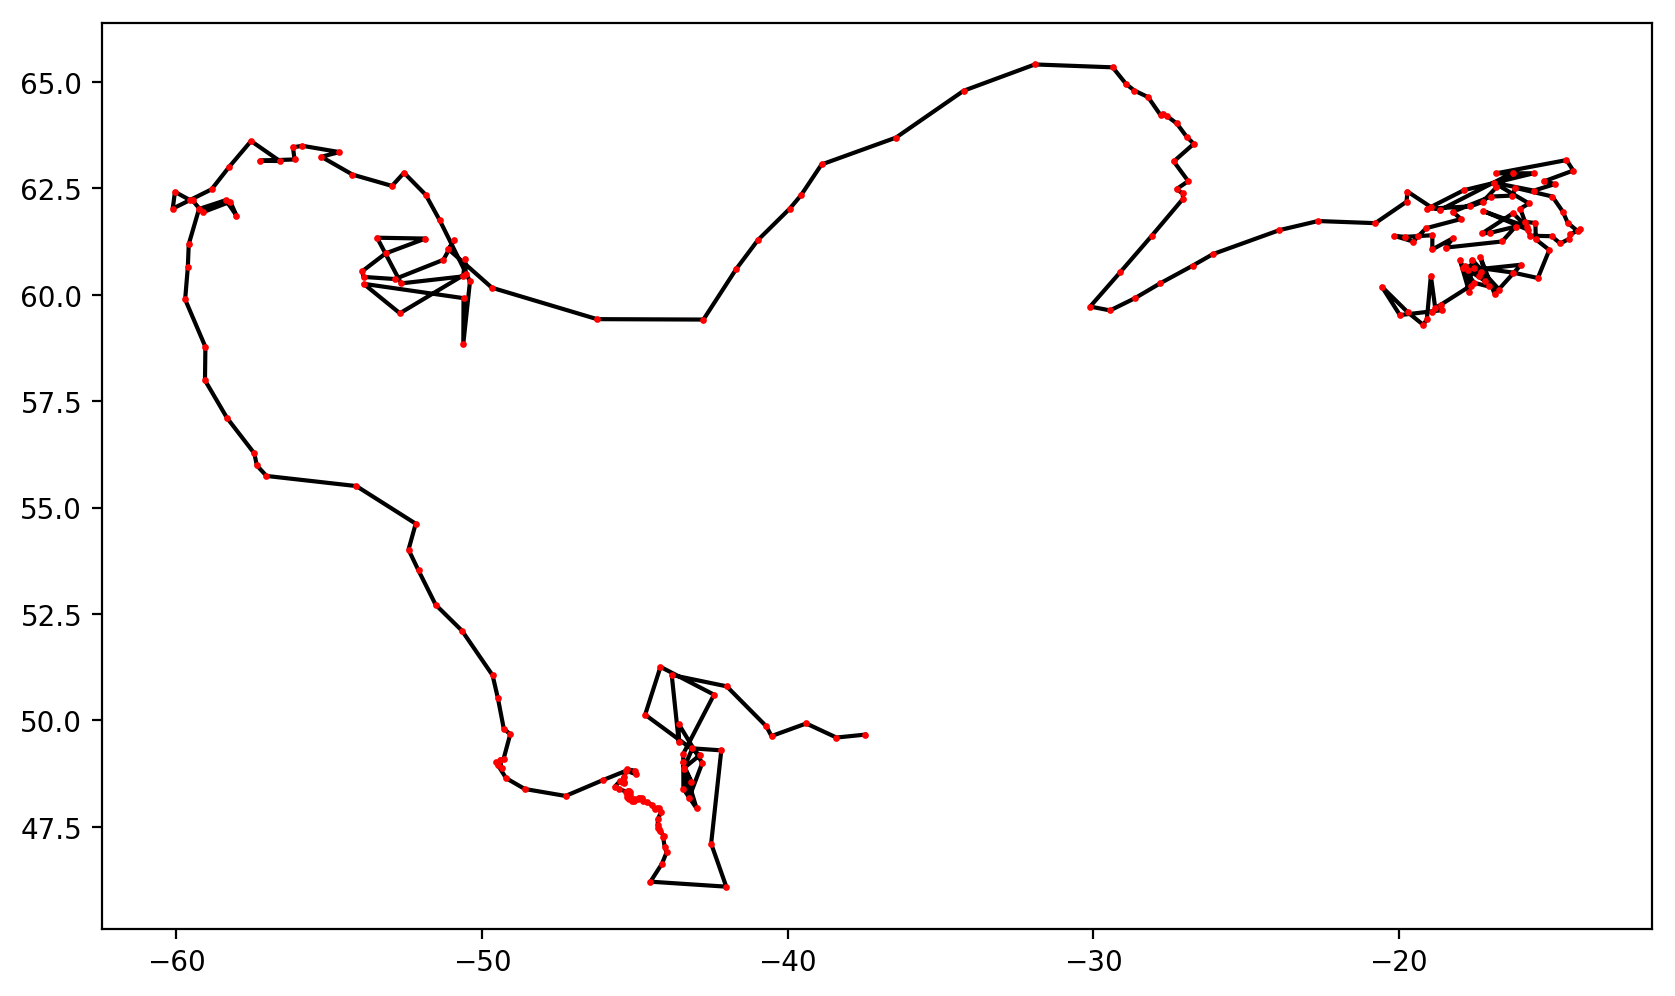

In [176]:
fig = plt.figure(figsize=(10,6), dpi=200)
ax = fig.add_subplot(1,1,1)
ax.plot(lon, lat, 'black', zorder=0)
ax.scatter(lon, lat, s=2, color='red', zorder=1)

In [164]:
# plot one profile
profile_file = 'dataset/argo_1901294/profiles/R1901294_001.nc'
file = Dataset(profile_file, 'r')
temp = file.variables['TEMP'][:].squeeze()
psal = file.variables['PSAL'][:].squeeze()
pres = file.variables['PRES'][:].squeeze()

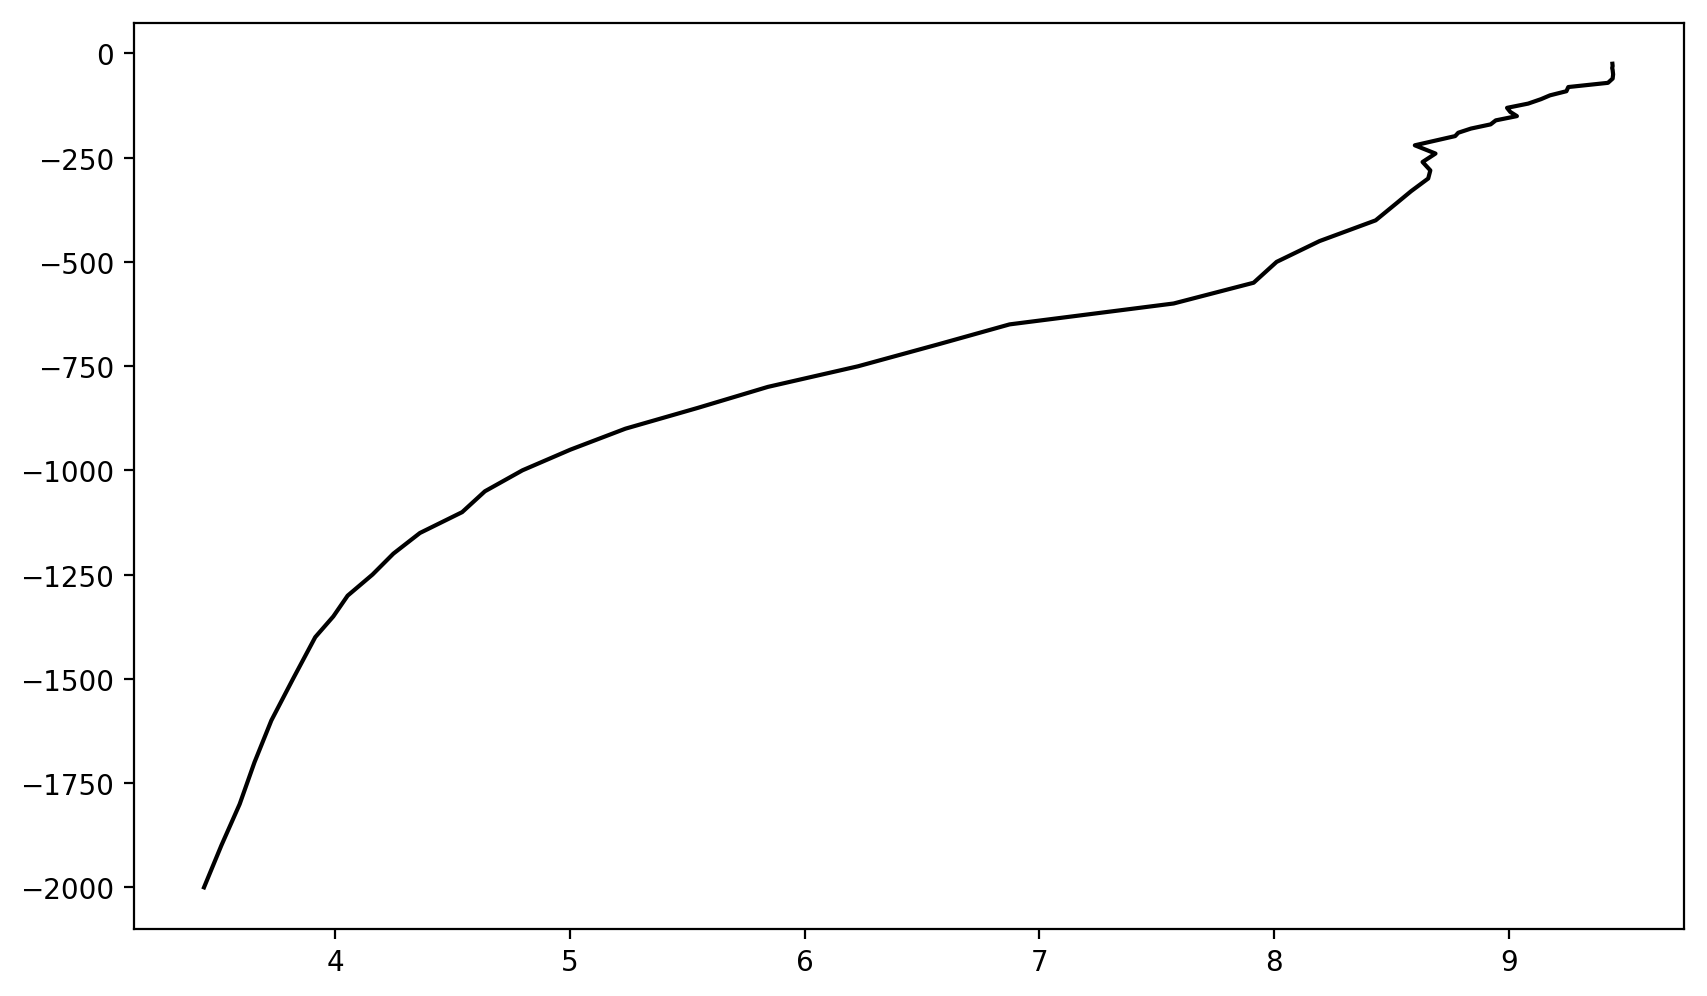

In [118]:
fig = plt.figure(figsize=(10,6), dpi=200)
ax = fig.add_subplot(1,1,1)
ax.plot(temp, -pres, 'black', zorder=0) # -press in dbar to get ~depth in meters

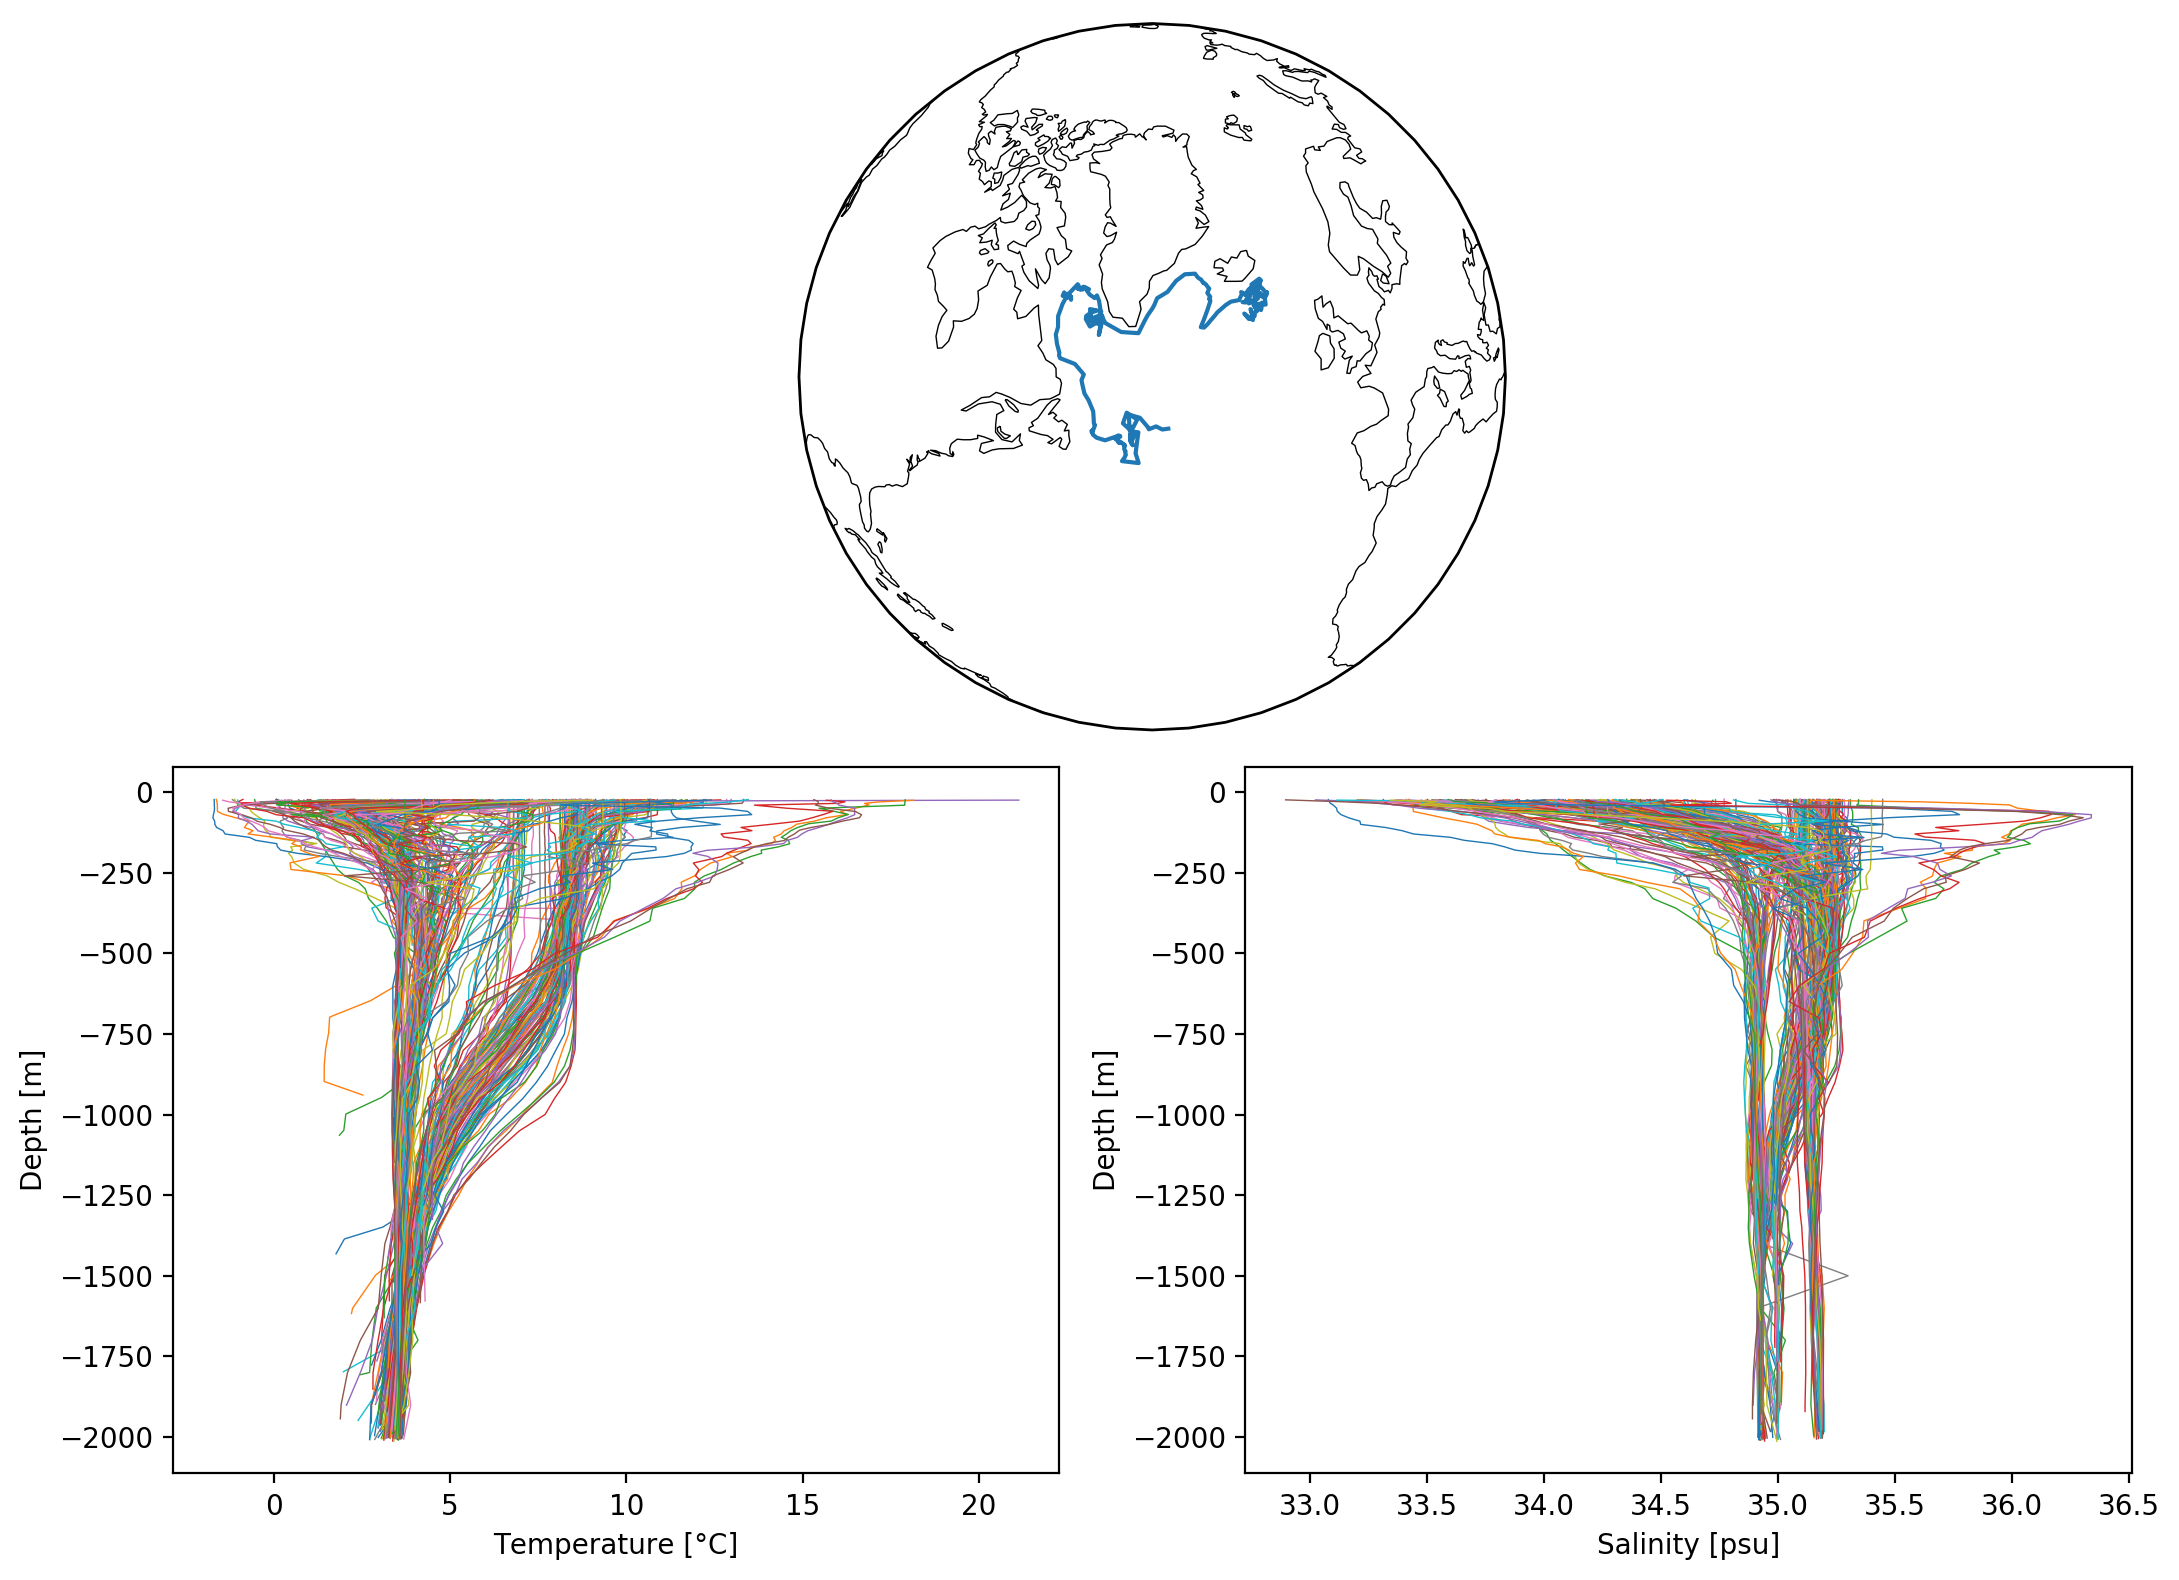

In [212]:
# plot all profiles of this float
fig = plt.figure(figsize=(11,8), dpi=200)
ax1 = fig.add_subplot(2,2,3)
ax2 = fig.add_subplot(2,2,4)

for i in range(1, 271):
    if i not in [150, 174, 213, 214]: # 150 has a wrong salinity point, the others are missing
        profile_file = 'dataset/argo_1901294/profiles/R1901294_%03d.nc' % i
        file = Dataset(profile_file, 'r')
        temp = file.variables['TEMP'][:].squeeze()
        psal = file.variables['PSAL'][:].squeeze()
        pres = file.variables['PRES'][:].squeeze()
        ax1.plot(temp, -pres, linewidth=0.5) # -press in dbar to get ~depth in meters
        ax2.plot(psal, -pres, linewidth=0.5) # -press in dbar to get ~depth in meters

        
ax1.set_xlabel('Temperature [°C]')
ax1.set_ylabel('Depth [m]')
ax2.set_xlabel('Salinity [psu]')
ax2.set_ylabel('Depth [m]')


# third axis for the trajectories with cartopy
import cartopy.crs as ccrs
ax3 = fig.add_subplot(2,1,1, projection=ccrs.NearsidePerspective(central_longitude=-40, central_latitude=55, satellite_height=10000000))
ax3.coastlines(linewidths=0.5)

datafile = 'dataset/argo_1901294/1901294_prof.nc'
file = Dataset(datafile, 'r')
lon = file.variables['LONGITUDE'][:]
lat = file.variables['LATITUDE'][:]
time = file.variables['JULD'][:]
ax3.plot(lon, lat, transform=ccrs.PlateCarree())
ax3.set_global()
fig.tight_layout()

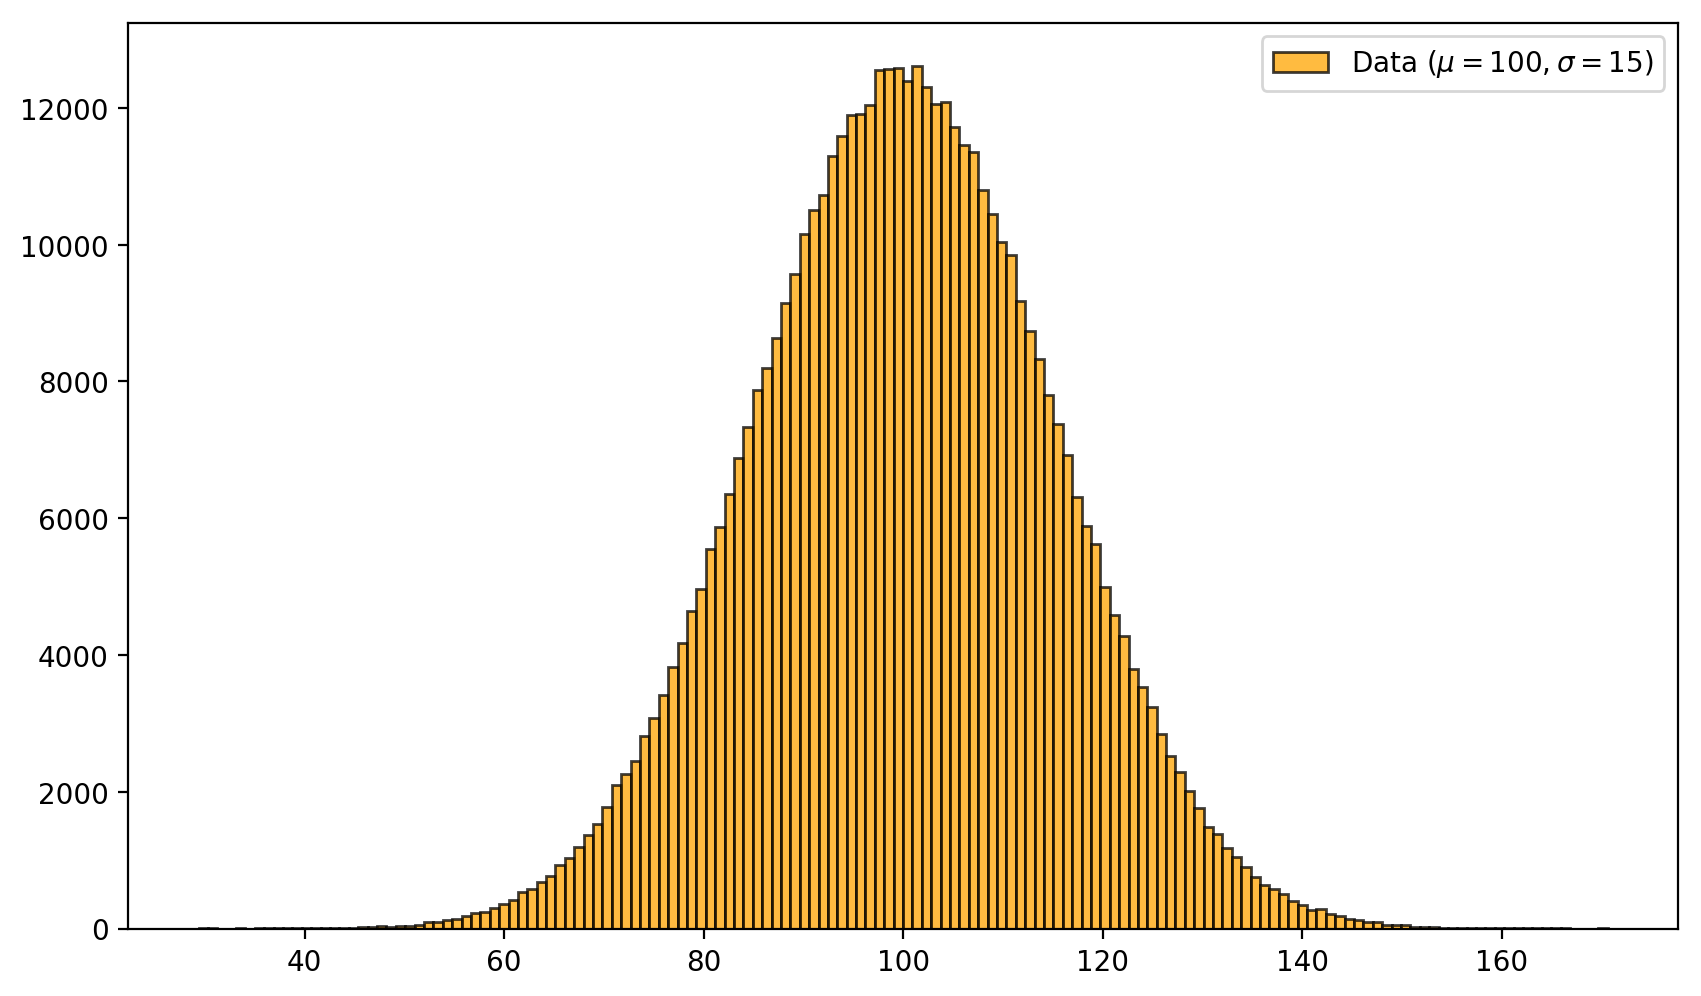

In [2]:
fig = plt.figure(figsize=(10,6), dpi=200)
ax = fig.add_subplot(1,1,1)

mu, sigma = 100, 15
x = mu + sigma*np.random.randn(500000)

# the histogram of the data
n, bins, patches = plt.hist(x, 150, facecolor='orange', edgecolor='black', alpha=0.75)
ax.legend(['Data ($\mu=%d, \sigma = %d$)' % (mu, sigma)])

# 2. Subplots

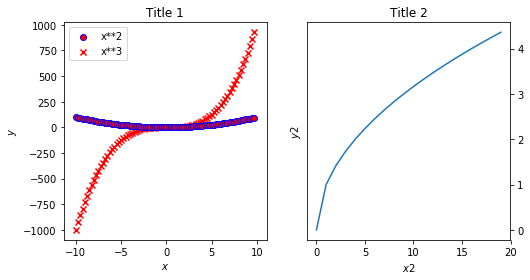

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

x = np.arange(-10,10,0.25)
line_x3 = ax1.scatter(x, x**3, marker='x', c='r', edgecolor='black')
line_x2 = ax1.scatter(x, x**2, marker='o', c='r', edgecolor='blue')

# by default the legend will use the lines in the order they were added to the axis
#ax1.legend(['x**2', 'x**3'], loc='upper left') # this would generate an inverted legend (!)

# otherwise we have to get a handle (l1, l2) and use them during the legend creation
ax1.legend([line_x2, line_x3], ['x**2', 'x**3'], loc='upper left')

ax1.set_title('Title 1')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

x = np.arange(0,20)
ax2.plot(x, np.sqrt(x))
ax2.set_title('Title 2')
ax2.set_xlabel('$x2$')
ax2.set_ylabel('$y2$')
ax2.yaxis.tick_right()

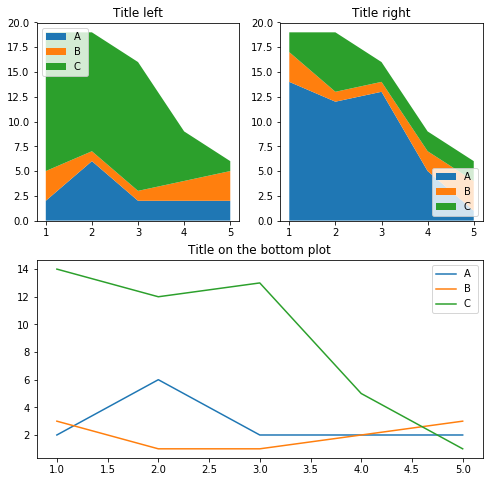

In [4]:
# data
x = [1, 2, 3, 4, 5]
y1 = np.random.randint(low=1, high=11, size=5)
y2 = np.random.randint(low=1, high=6, size=5)
y3 = np.random.randint(low=1, high=20, size=5)

labels = ["A ", "B", "C"]

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2,2,1)
ax1.stackplot(x, y1, y2, y3, labels=labels)
ax1.set_title('Title left')
ax1.legend(loc='upper left')

# the data can be also join together with numpy
ax2 = fig.add_subplot(2,2,2)
ax2.stackplot(x, np.vstack([y3, y2, y1]), labels=labels) 
ax2.set_title('Title right')
ax2.legend(loc='lower right')

# bottom plot takes all width
ax3 = fig.add_subplot(2,1,2)
ax3.plot(x, y1, x, y2, x, y3)
ax3.set_title('Title on the bottom plot')
ax3.legend(labels)

# Importances of colormap


## cmocean
https://matplotlib.org/cmocean/




In [5]:
# from https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/
def grayify_cmap(cmap):
    """Return a grayscale version of the colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived greyscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    return cmap.from_list(cmap.name + "_grayscale", colors, cmap.N)

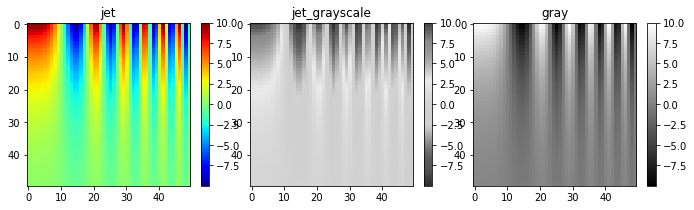

In [6]:
x = np.linspace(0, 6)
y = np.linspace(0, 3)[:, np.newaxis]
z = 10 * np.cos(x ** 2) * np.exp(-y)

cmaps = [plt.cm.jet, grayify_cmap('jet'), plt.cm.gray]
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
fig.subplots_adjust(wspace=0)

for cmap, ax in zip(cmaps, axes):
    im = ax.imshow(z, cmap=cmap)
    ax.set_title(cmap.name)
    fig.colorbar(im, ax=ax)

# Gridplot, meshplot and collections

# Mapping with Cartopy

In [7]:
import cartopy.crs as ccrs

## Trying the different projections

### PlateCarree parameters
- central_longitude=0.0

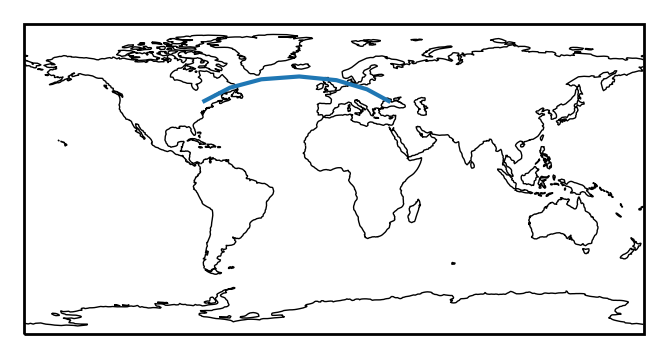

In [42]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidths=0.5)

x = np.array([-75, 32])
y = np.array([45, 45])
ax.plot(x,y,transform=ccrs.Geodetic())

# by default once you plot, the map will be zoom to the data
ax.set_global()

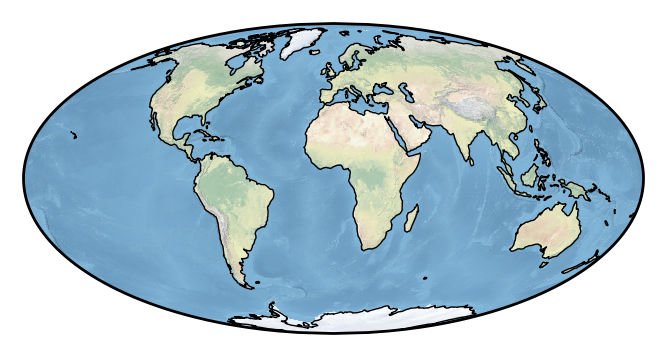

In [53]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = fig.add_subplot(1,1,1,projection=ccrs.Mollweide())
ax.stock_img() # add an image on top of the current projections
ax.coastlines(linewidths=0.5)

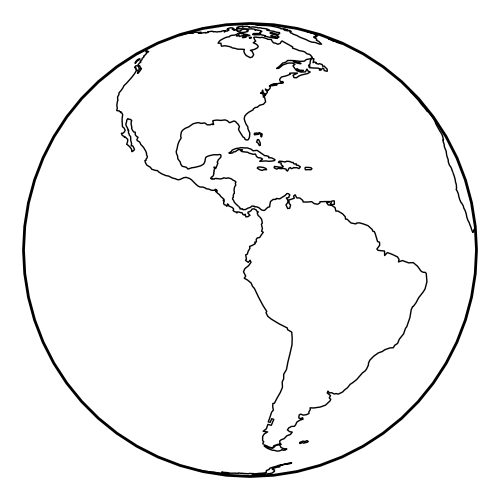

In [54]:
## Geostationary
fig = plt.figure(figsize=(3, 3), dpi=200)
ax = plt.axes(projection=ccrs.Geostationary(central_longitude = -80))
ax.coastlines(linewidths=0.5)

### NorthPolarStereo and SouthPolarStereo

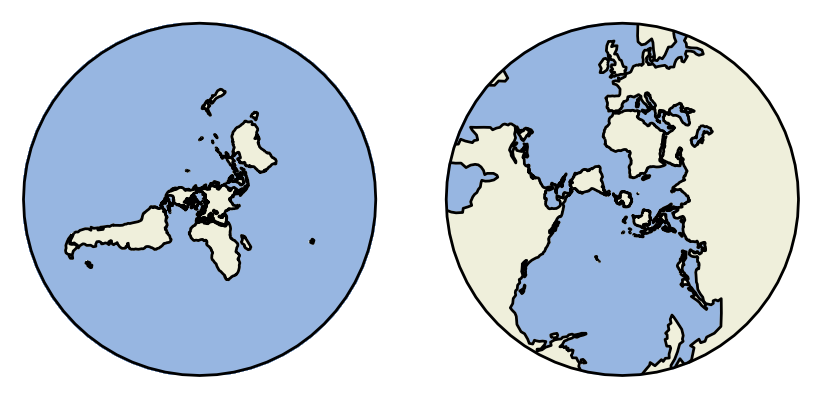

In [14]:
# from cartopy.feature we can add all kinds of map element
from cartopy.feature import OCEAN, LAND, COASTLINE

fig = plt.figure(figsize=(5, 4), dpi=200)

# looping two opposite projections
projections = [ccrs.NorthPolarStereo(), ccrs.SouthPolarStereo()]
for i, proj in enumerate(projections):
    ax = fig.add_subplot(1, 2, i+1, projection=proj)
    ax.coastlines(linewidths=0.5)
    ax.add_feature(OCEAN)
    ax.add_feature(COASTLINE)
    ax.add_feature(LAND)

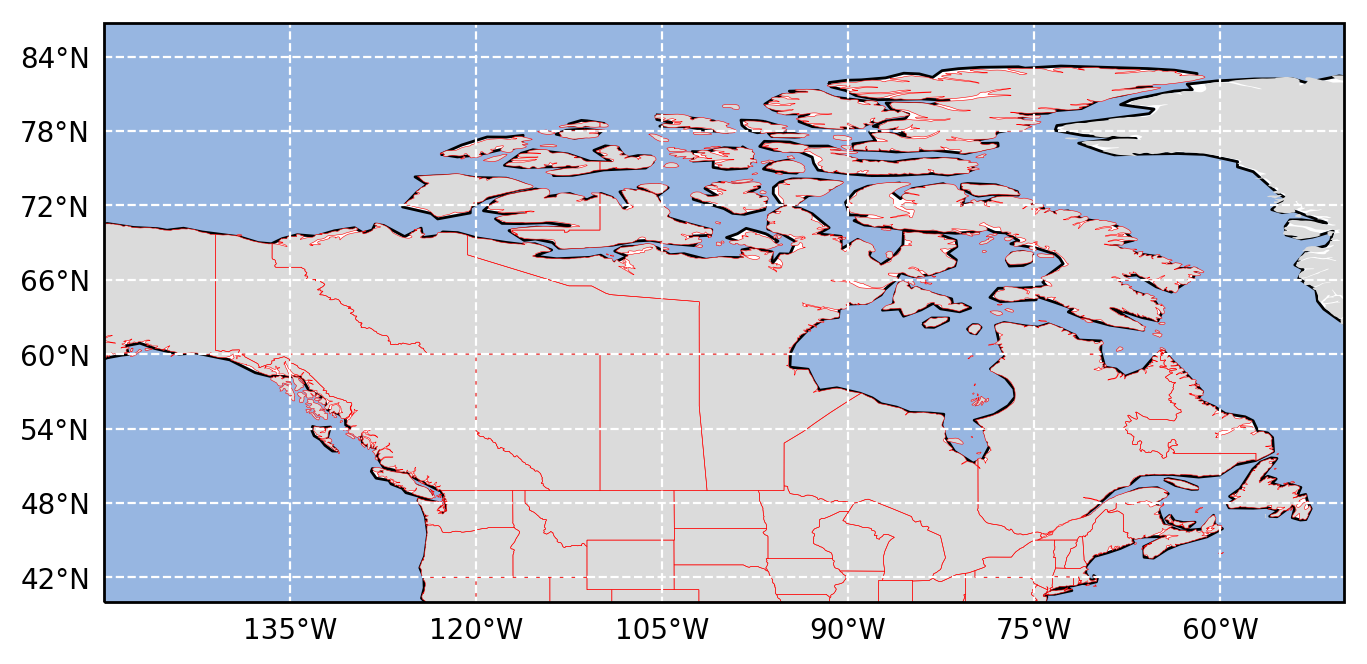

In [12]:
from cartopy.feature import NaturalEarthFeature, COLORS, OCEAN, LAND, COASTLINE
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# see features interface for more details about the parameters and different data available
# https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html

fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-150, -50, 40, 85])

# color land and ocean
ax.add_feature(OCEAN)
ax.add_feature(COASTLINE)
# ax.add_feature(LAND) like OCEAN and COASTLINES are shortcuts
land_50m = NaturalEarthFeature('physical', 'land', '50m', facecolor=COLORS['land_alt1'])
ax.add_feature(land_50m)

# add provinces again from NaturalEarthFeature
# this time it's in the 'cultural' category
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                         name='admin_1_states_provinces_shp')
ax.add_feature(states, edgecolor='red', linewidths=0.2)

# modify the labels
gl = ax.gridlines(draw_labels=True, linestyle='--', color='white')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

Text(0.5,1,'Who uses this projection ?')

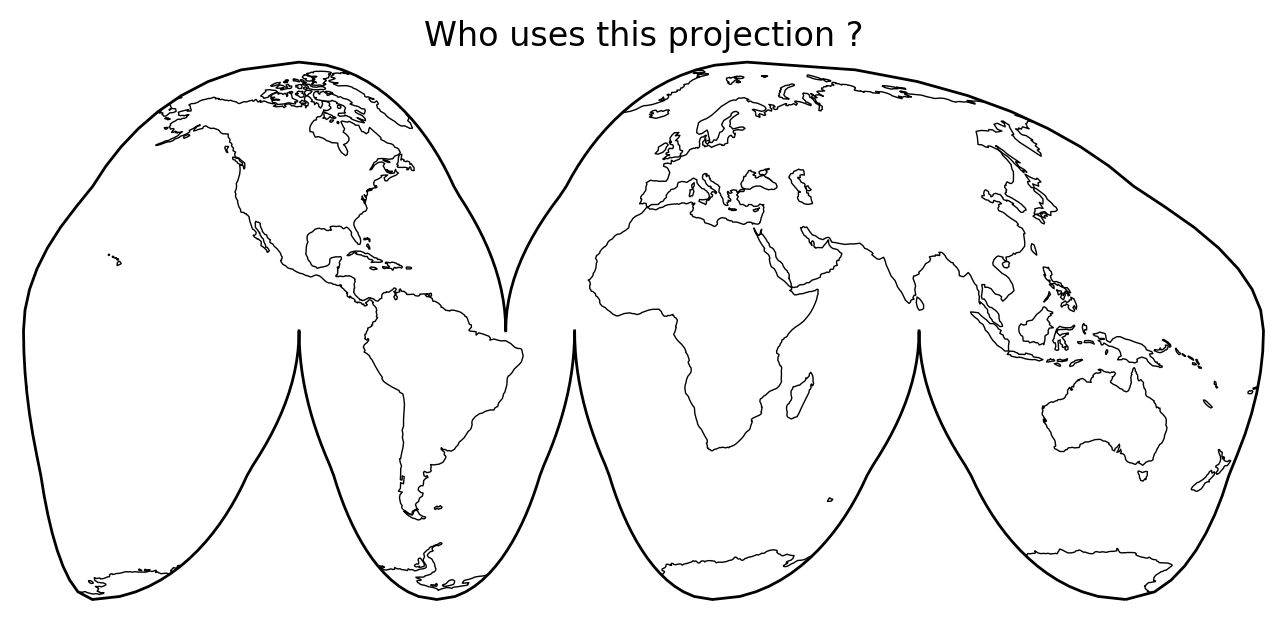

In [13]:
fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.InterruptedGoodeHomolosine())
ax.coastlines(linewidths=0.5)
plt.title('Who uses this projection ?')

# Bathymetry from external dataset

ETOPO1 is a 1 arc-minute global relief model of Earth's surface that integrates land topography and ocean bathymetry.

# Retriving data from THREED server - GOES 17

In [23]:
from datetime import datetime
from siphon.catalog import TDSCatalog # https://unidata.github.io/siphon/
import metpy
import xarray as xr

# get the latest SeaSurfaceTemperature from GOES 16
nowdate = datetime.utcnow()
catalog = TDSCatalog('http://thredds-jumbo.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/' 
                     + 'Products/SeaSurfaceTemperature/FullDisk/' 
                     + \str(nowdate.year) + str("%02d"%nowdate.month) + str("%02d"%nowdate.day) 
                     + '/catalog.xml')

info = """
Catalog information
-------------------

Base THREDDS URL: {}
Catalog name: {}
Catalog URL: {}
Metadata: {}
""".format(catalog.base_tds_url,
           catalog.catalog_name,
           catalog.catalog_url,
           catalog.metadata)

print(info)


Catalog information
-------------------

Base THREDDS URL: http://thredds-jumbo.unidata.ucar.edu
Catalog name: No name found
Catalog URL: http://thredds-jumbo.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Products/SeaSurfaceTemperature/FullDisk/20181009/catalog.xml
Metadata: {'inherited': True, 'serviceName': 'GridServices', 'dataType': 'GRID', 'documentation': {'generic': ["NOAA's GOES-17 satellite has not been declared operational and its data are preliminary and undergoing testing. Users receiving these data through any dissemination means (including, but not limited to, PDA and GRB) assume all risk related to their use of GOES-17 data and NOAA disclaims any and all warranties, whether express or implied, including (without limitation) any implied warranties of merchantability or fitness for a particular purpose."]}}



In [24]:
# different services available
# not sure what this means ? I'm still learning!
for service in catalog.services:
    print(service.name)

latest
fullServices
GridServices


In [25]:
# we retrieved all the datasets of today
print('\n'.join(catalog.datasets.keys()))

OR_ABI-L2-SSTF-M3_G16_s20182812300379_e20182812356146_c20182820000251.nc
OR_ABI-L2-SSTF-M3_G16_s20182820000379_e20182820056146_c20182820100285.nc
OR_ABI-L2-SSTF-M3_G16_s20182820100379_e20182820156146_c20182820200403.nc
OR_ABI-L2-SSTF-M3_G16_s20182820200379_e20182820256146_c20182820300543.nc
OR_ABI-L2-SSTF-M3_G16_s20182820300380_e20182820356146_c20182820400298.nc


In [26]:
# sort and get the latest (last) elementss
latest_dataset = sorted(catalog.datasets.keys())[-1]
dataset = catalog.datasets[latest_dataset]

# we now create an xarray from the data on the netCDF on the server
ds = dataset.remote_access(service='OPENDAP', use_xarray=True)

In [27]:
# parse the results to be able to plot it on any cartopy projections later
dqf = ds.metpy.parse_cf('DQF')  # [0,1,2,3] quality of values
dat = ds.metpy.parse_cf('SST')  # SST

In [33]:
# the data now have a projection associated with them
print(dat.metpy.cartopy_crs)

In [28]:
dat = dat.where(dqf == 0) # keep only values where quality is good
dat = dat.where(dat.variable > 273.15)
dat = dat.where(dat.variable < 320)
dat = dat - 273.15 # to Celsius

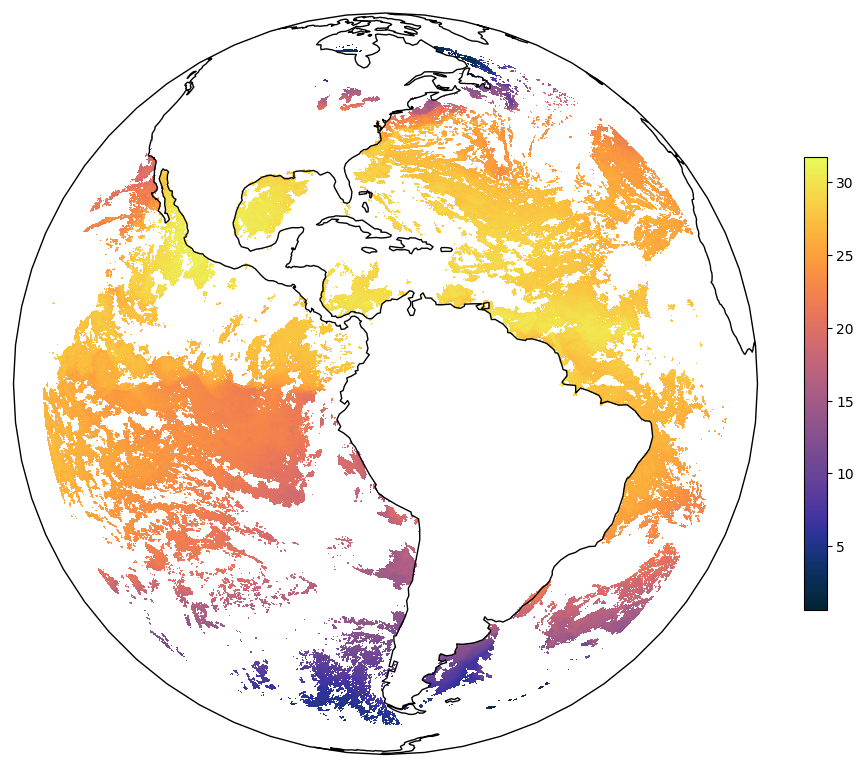

In [31]:
fig = plt.figure(figsize=[12, 12], dpi=100)
ax = fig.add_subplot(1,1,1, projection=dat.metpy.cartopy_crs) # metpy projection from the data
ax.coastlines(linewidths=0.5)

im = ax.pcolormesh(dat['x'], dat['y'], dat, cmap=cmocean.cm.thermal, 
                   transform=dat.metpy.cartopy_crs, vmin=dat.min(), vmax=dat.max())

plt.colorbar(im, shrink=0.5)

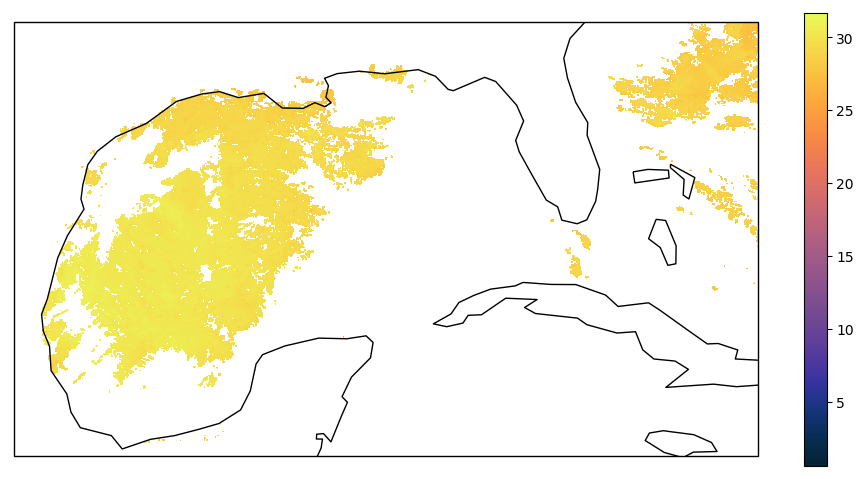

In [32]:
# zoom gulf of mexico
fig = plt.figure(figsize=[12, 12], dpi=100)

ax = fig.add_subplot(1,1,1, projection=dat.metpy.cartopy_crs) # metpy projection from the data
ax.set_extent([-98,-75, 18, 32])
ax.coastlines(linewidths=0.5)

im = ax.pcolormesh(dat['x'], dat['y'], dat, cmap=cmocean.cm.thermal, 
                   transform=dat.metpy.cartopy_crs, vmin=dat.min(), vmax=dat.max())

plt.colorbar(im, shrink=0.5)